In [1]:
import sys
sys.path.append('../..')
import argparse
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from bundlenet_continuous_variant import BunDLeNet, train_model
from functions import preprocess_data, prep_data, plotting_neuronal_behavioural, plot_latent_timeseries
from plotting_functions import plot_phase_space

import os
os.chdir('../..')

2024-02-19 15:06:46.758482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 15:06:46.758521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 15:06:46.759605: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 15:06:46.765296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 15:06:47.539720: W tensorflow/compiler/tf2

In [2]:
os.getcwd()

'/home/akshey/Desktop/PhD/Code_repositories/BunDLe-Net'

## Load Data

In [70]:
#path_neuronal_data ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/220210_F2_F2_run5_cells_fluorescence_signals.npy' 
path_neuronal_data ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/220210_F2_F2_run5_cells_spike_rate_signals.npy' 
path_behaviour_data1 ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/directionality.npy'
path_behaviour_data2 ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/vigour.npy'

X = np.load(path_neuronal_data).T
B1 = np.load(path_behaviour_data1)
B2 = np.load(path_behaviour_data2)
B = np.c_[B1, B2]

### Remove NaNs
B = B[~np.isnan(X[:,0])]
X = X[~np.isnan(X[:,0])]
B.shape, X.shape

### Scaling
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
B = StandardScaler(with_mean=False).fit_transform(B)
X = StandardScaler(with_mean=False).fit_transform(X)

In [71]:
B.shape, X.shape

((3333, 2), (3333, 1126))

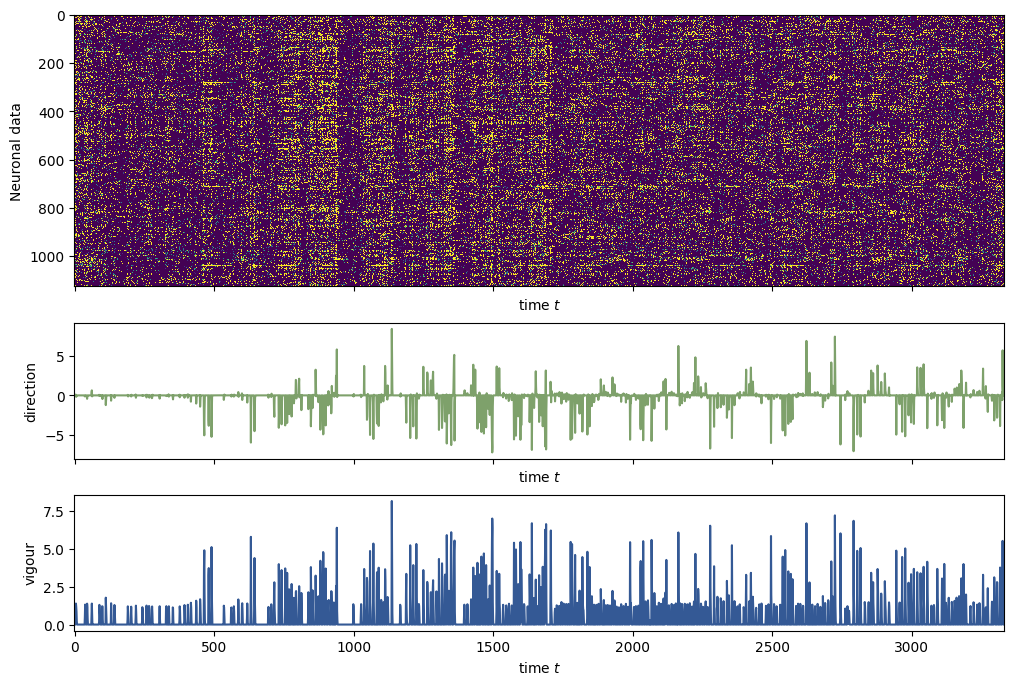

In [72]:
def plotting_neuronal_behavioural(X,B, state_names=[], **kwargs):
    fig, axs = plt.subplots(3,1,figsize=(12,8),  sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})
    im0 = axs[0].imshow(X.T,aspect='auto', interpolation='None', **kwargs)
    # tell the colorbar to tick at integers
    axs[0].set_xlabel("time $t$")
    axs[0].set_ylabel("Neuronal data")
    
    colors = ['#7EA16B', '#345995', '#AF125A']
    ylabels = ['direction', 'vigour']
    for i in range(2):
        # Behaviour 1
        im1 = axs[i+1].plot(B[:,i], c=colors[i])
        axs[i+1].set_xlabel("time $t$")
        axs[i+1].set_ylabel(ylabels[i])
        #axs[i+1].set_yticks([])

    plt.show()
    
plotting_neuronal_behavioural(X,B, vmin=0, vmax=1)

## BunDLe-Net

In [90]:
algorithm = 'BunDLeNet'
X_, B_ = prep_data(X, B, win=10)

### Deploy BunDLe Net
model = BunDLeNet(latent_dim=3, num_behaviour=B_.shape[1])
model.build(input_shape=X_.shape)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

#X_train, X_test, B_train, B_test = timeseries_train_test_split(X_, B_)
loss_array = train_model(X_,
             B_, 
             model,
             optimizer,
             gamma=0.9, 
             n_epochs=500,
             pca_init=False,
             best_of_5_init=False
                         )

Losses 0.027384 0.014429 0.041813: 100%|██████| 500/500 [01:57<00:00,  4.24it/s]


<IPython.core.display.Javascript object>


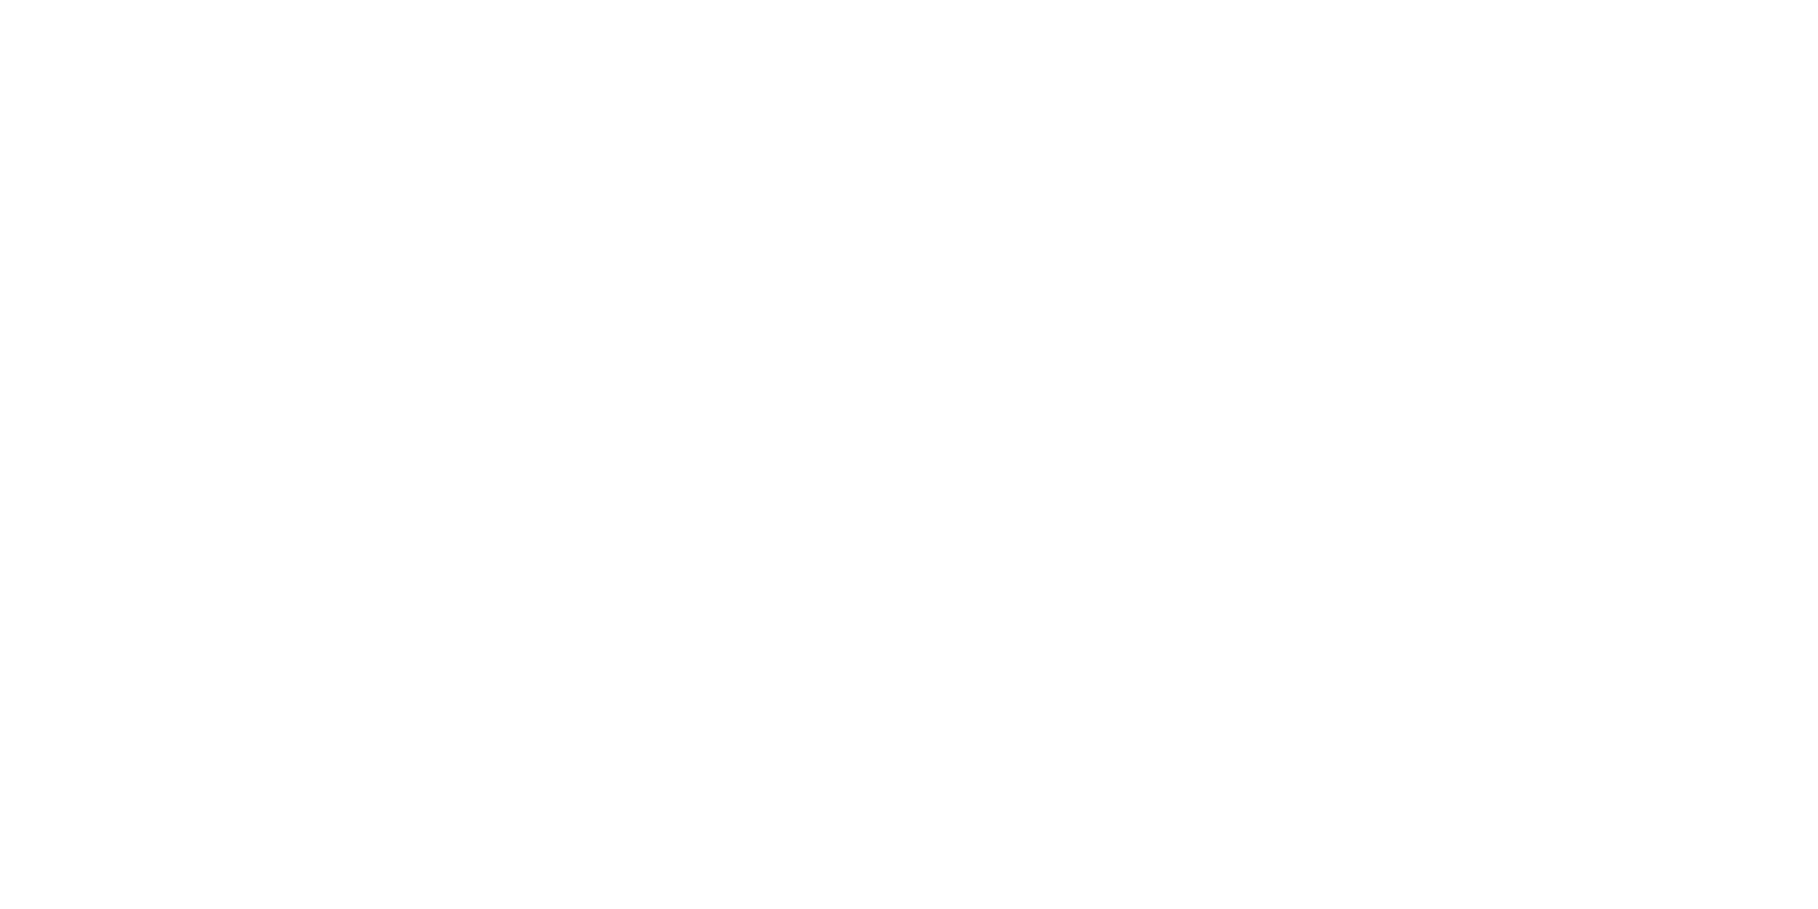

<IPython.core.display.Javascript object>


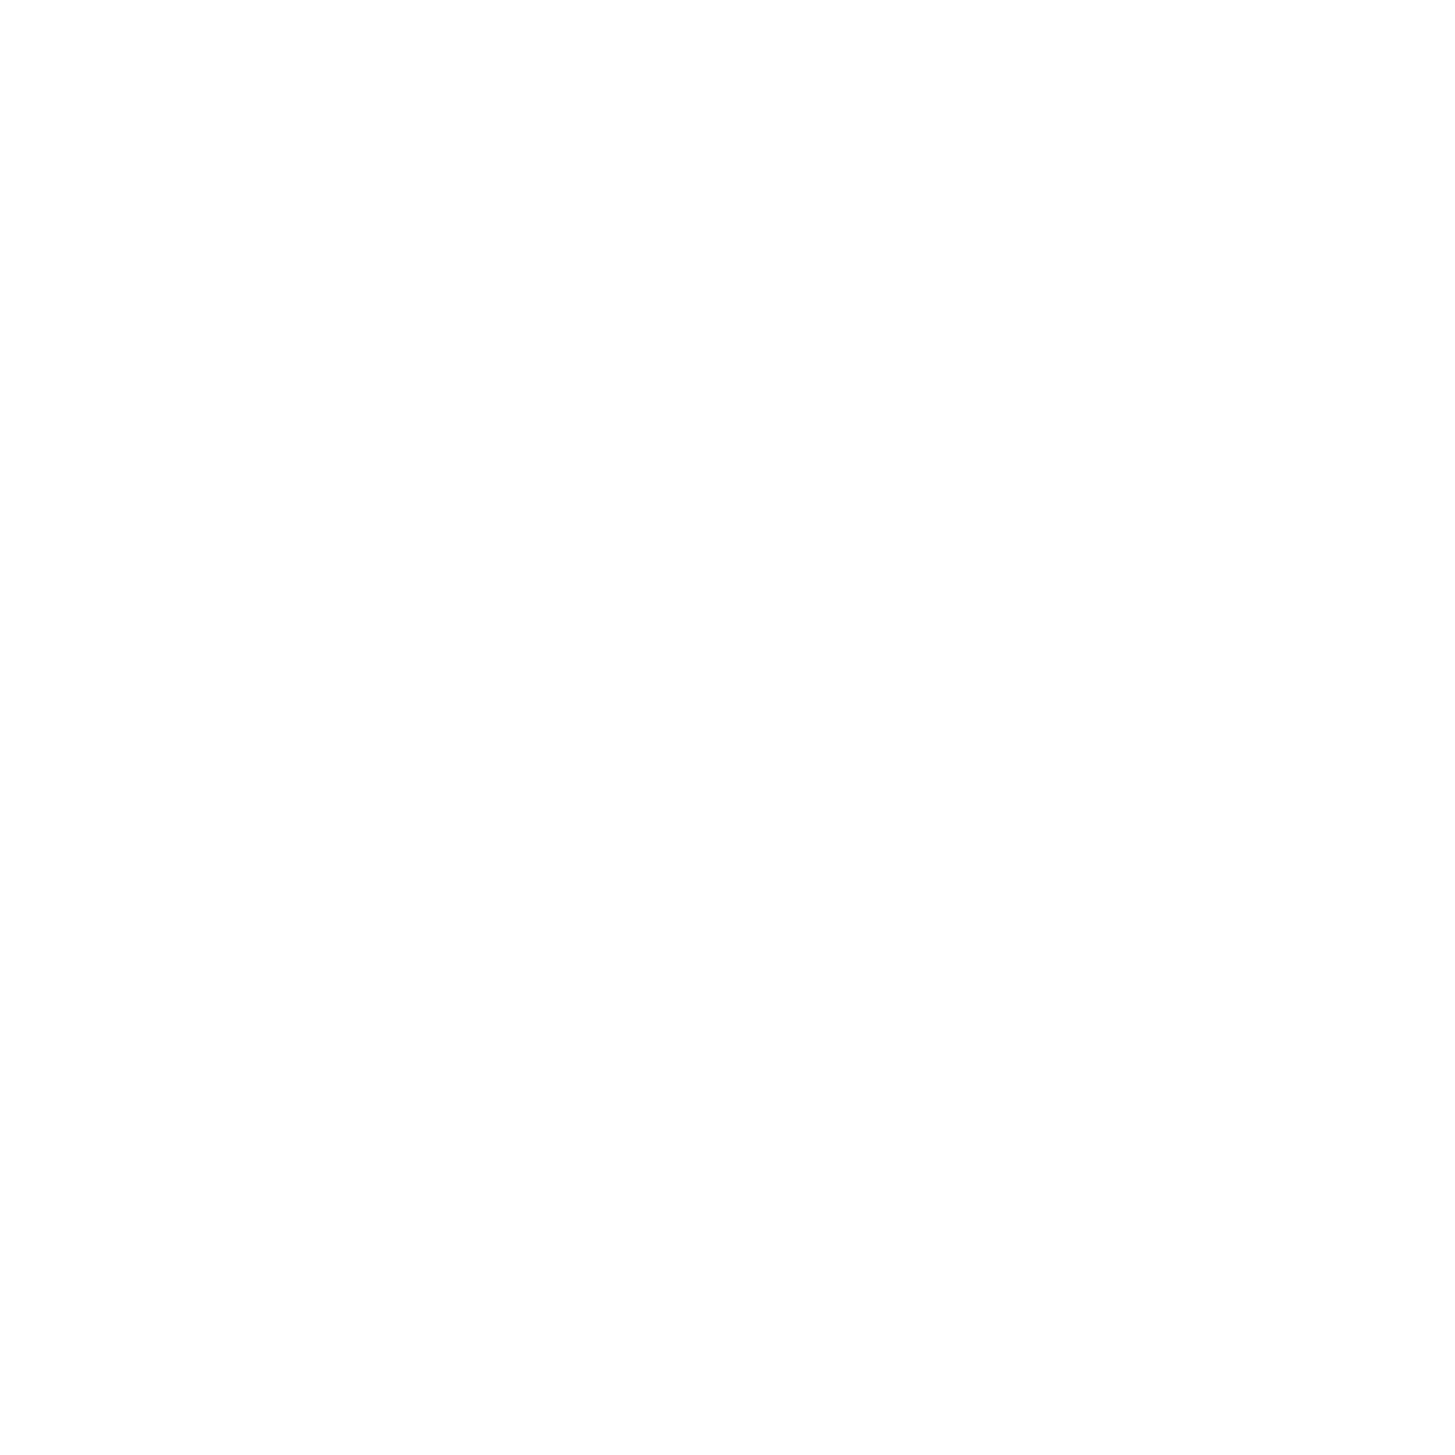

<IPython.core.display.Javascript object>


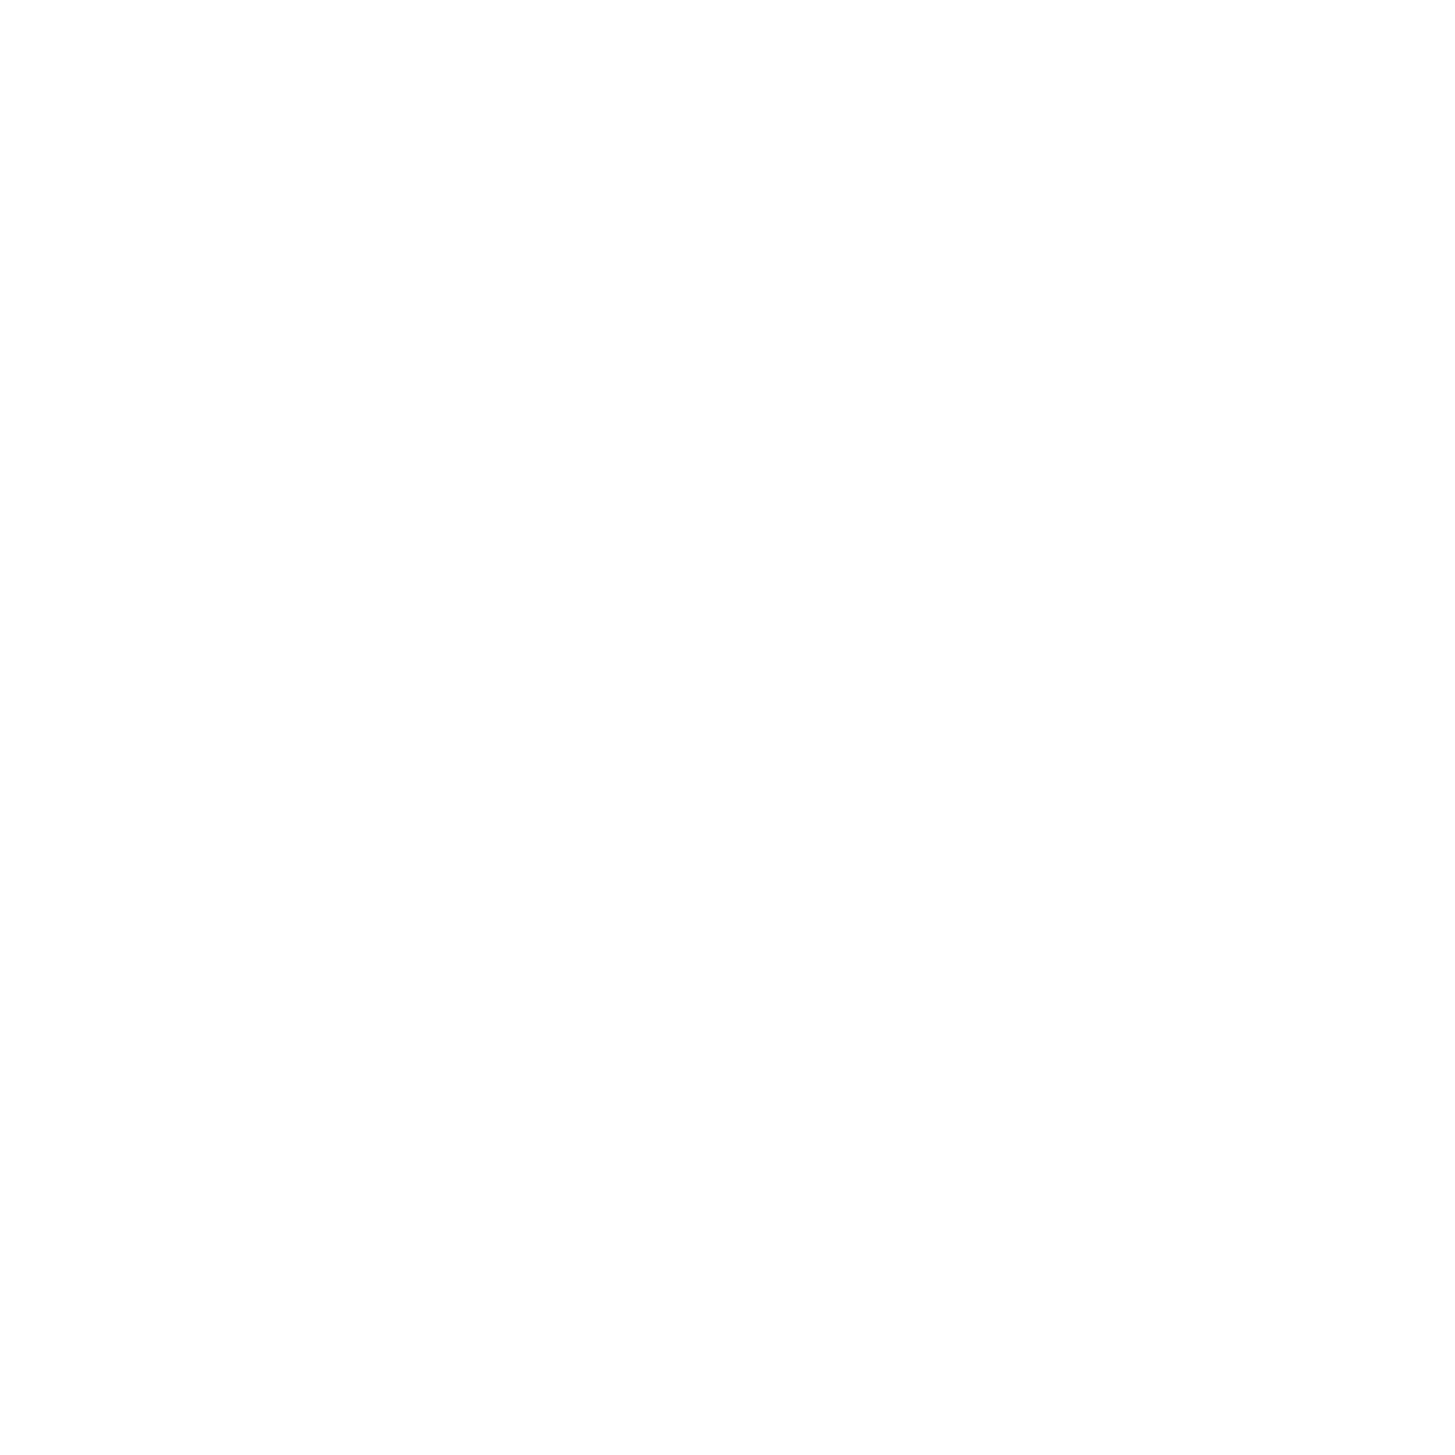

<IPython.core.display.Javascript object>


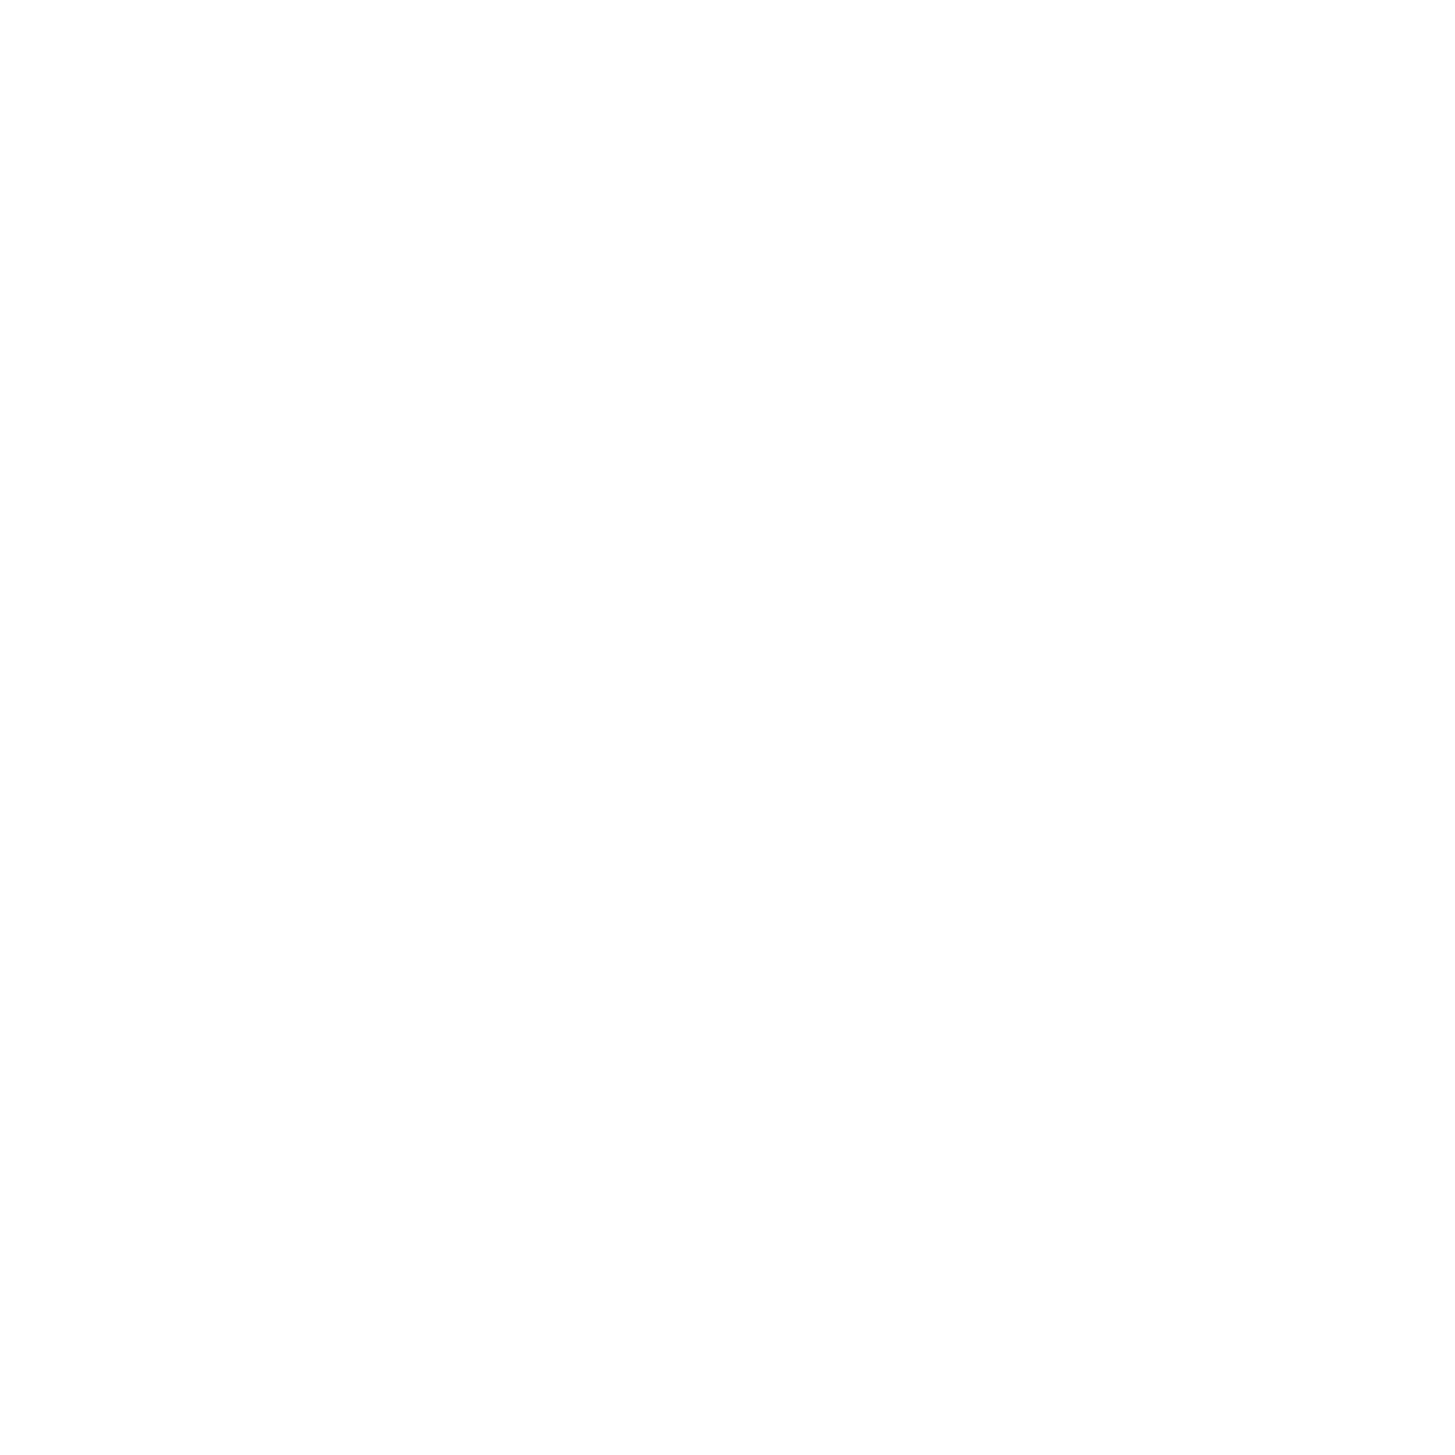

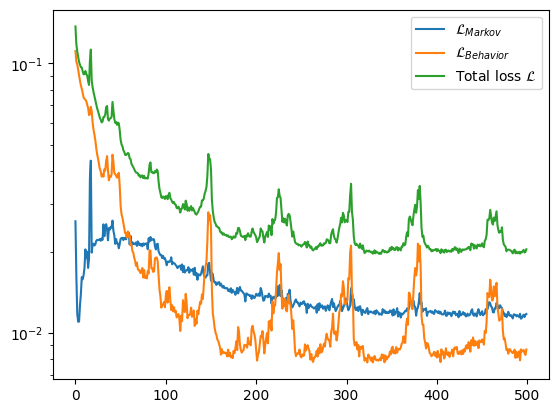

In [91]:
%matplotlib inline
# Training losses vs epochs
plt.figure()
for i, label in  enumerate(["$\mathcal{L}_{{Markov}}$", "$\mathcal{L}_{{Behavior}}$","Total loss $\mathcal{L}$" ]):
    plt.semilogy(loss_array[:,i], label=label)

    
plt.legend()
plt.show()

## Projecting into latent space

In [92]:
### Projecting into latent space
Y0_ = model.tau(X_[:,0]).numpy()


In [ ]:

os.makedirs('data/generated/saved_Y/fish', exist_ok=True)
np.savetxt('data/generated/saved_Y/fish/Y0__' + algorithm + '_fish_' + str('F2'), Y0_)
np.savetxt('data/generated/saved_Y/fish/B__' + algorithm + '_fish_' + str('F2'), B_)

In [59]:
Y0_ = np.loadtxt('data/generated/saved_Y/fish/Y0__BunDLeNet_fish_F2')
B_ = np.loadtxt('data/generated/saved_Y/fish/B__BunDLeNet_fish_F2')

## Visualising embedding

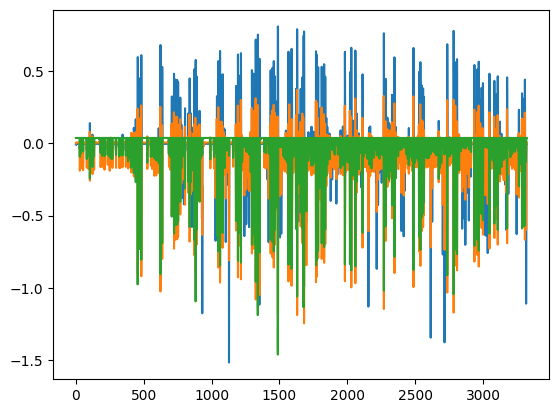

In [93]:
%matplotlib inline
plt.figure()
plt.plot(Y0_)

<IPython.core.display.Javascript object>


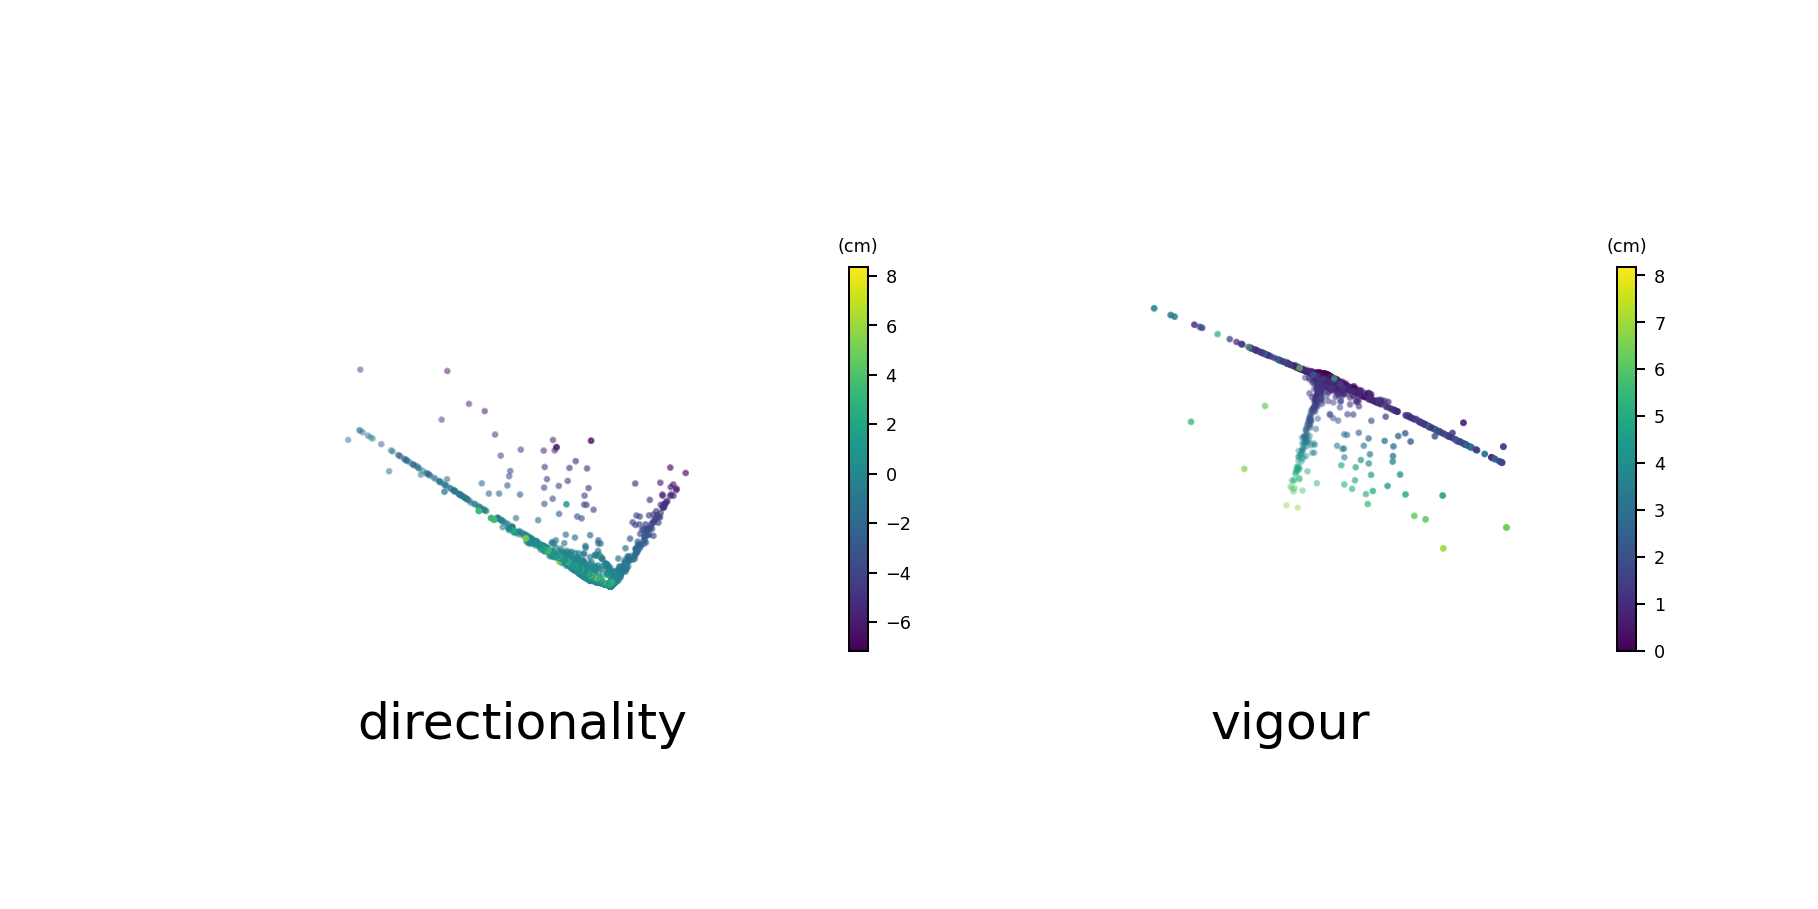

In [94]:
%matplotlib notebook
def plot_embedding(Y0_, B_, title=None, **kwargs):
    elev, azim, roll = 27,10,0
    fig = plt.figure(figsize=(10, 5))
    plt.suptitle(title,
                 fontsize=20)
    ax = plt.subplot(121, projection = '3d')
    ax.view_init(**kwargs)
    ax.set_title('directionality', fontsize=20, y=0)
    x = ax.scatter(Y0_[:, 0],
                   Y0_[:, 1],
                   Y0_[:, 2],
                   c=B_[:, 0],
                   cmap='viridis',
                   s=3
    )
    ax.axis('off')
    xc = plt.colorbar(x, fraction=0.03, pad=0.05)
    xc.ax.tick_params(labelsize=7)
    xc.ax.set_title("(cm)", fontsize=7)

    ax = plt.subplot(122, projection = '3d')
    ax.view_init(**kwargs)
    y = ax.scatter(Y0_[:, 0],
                   Y0_[:, 1],
                   Y0_[:, 2],
                   c=B_[:, 1],
                   cmap='viridis',
                   s=3
    )
    ax.axis('off')
    ax.set_title('vigour', fontsize=20, y=0)
    yc = plt.colorbar(y, fraction=0.03, pad=0.05)
    yc.ax.tick_params(labelsize=7)
    yc.ax.set_title("(cm)", fontsize=7)
    plt.show()

plot_embedding(Y0_, B_, azim=20 )

<IPython.core.display.Javascript object>


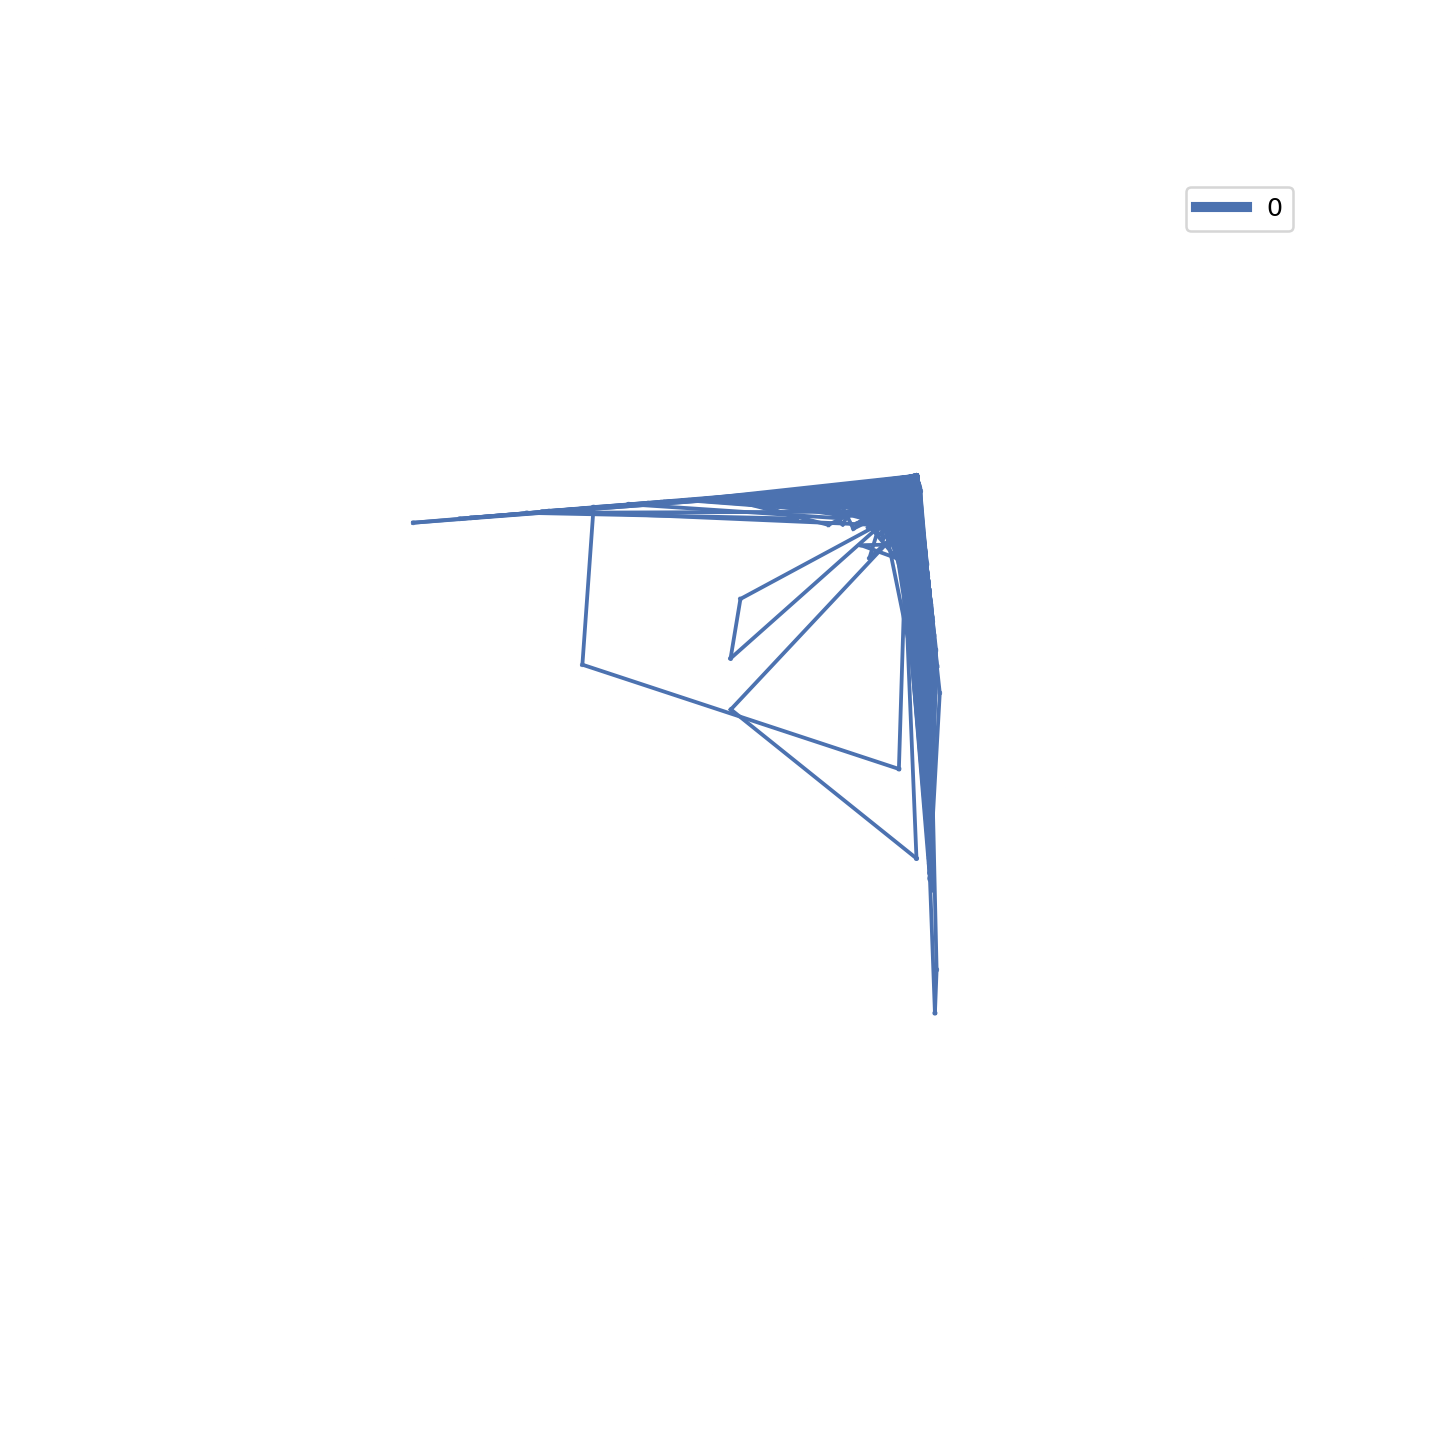

(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [95]:
plot_phase_space(Y0_, np.zeros_like(B_[:,0], dtype=int), state_names=['0'])

---------------------

# Comparision with other embedding algorithms

## PCA

In [87]:
from sklearn.decomposition import PCA
dim = 3
pca = PCA(n_components=dim)
pca.fit(X_[:,0,0,:]) ###################### use X instead of X_
print('Percentage of variance explained by the first ', dim, ' PCs: ', pca.explained_variance_ratio_[:dim].sum().round(3))

### Projecting into latent space
Y0_pca = pca.transform(X_[:,0,0,:])

Percentage of variance explained by the first  3  PCs:  0.171


<IPython.core.display.Javascript object>


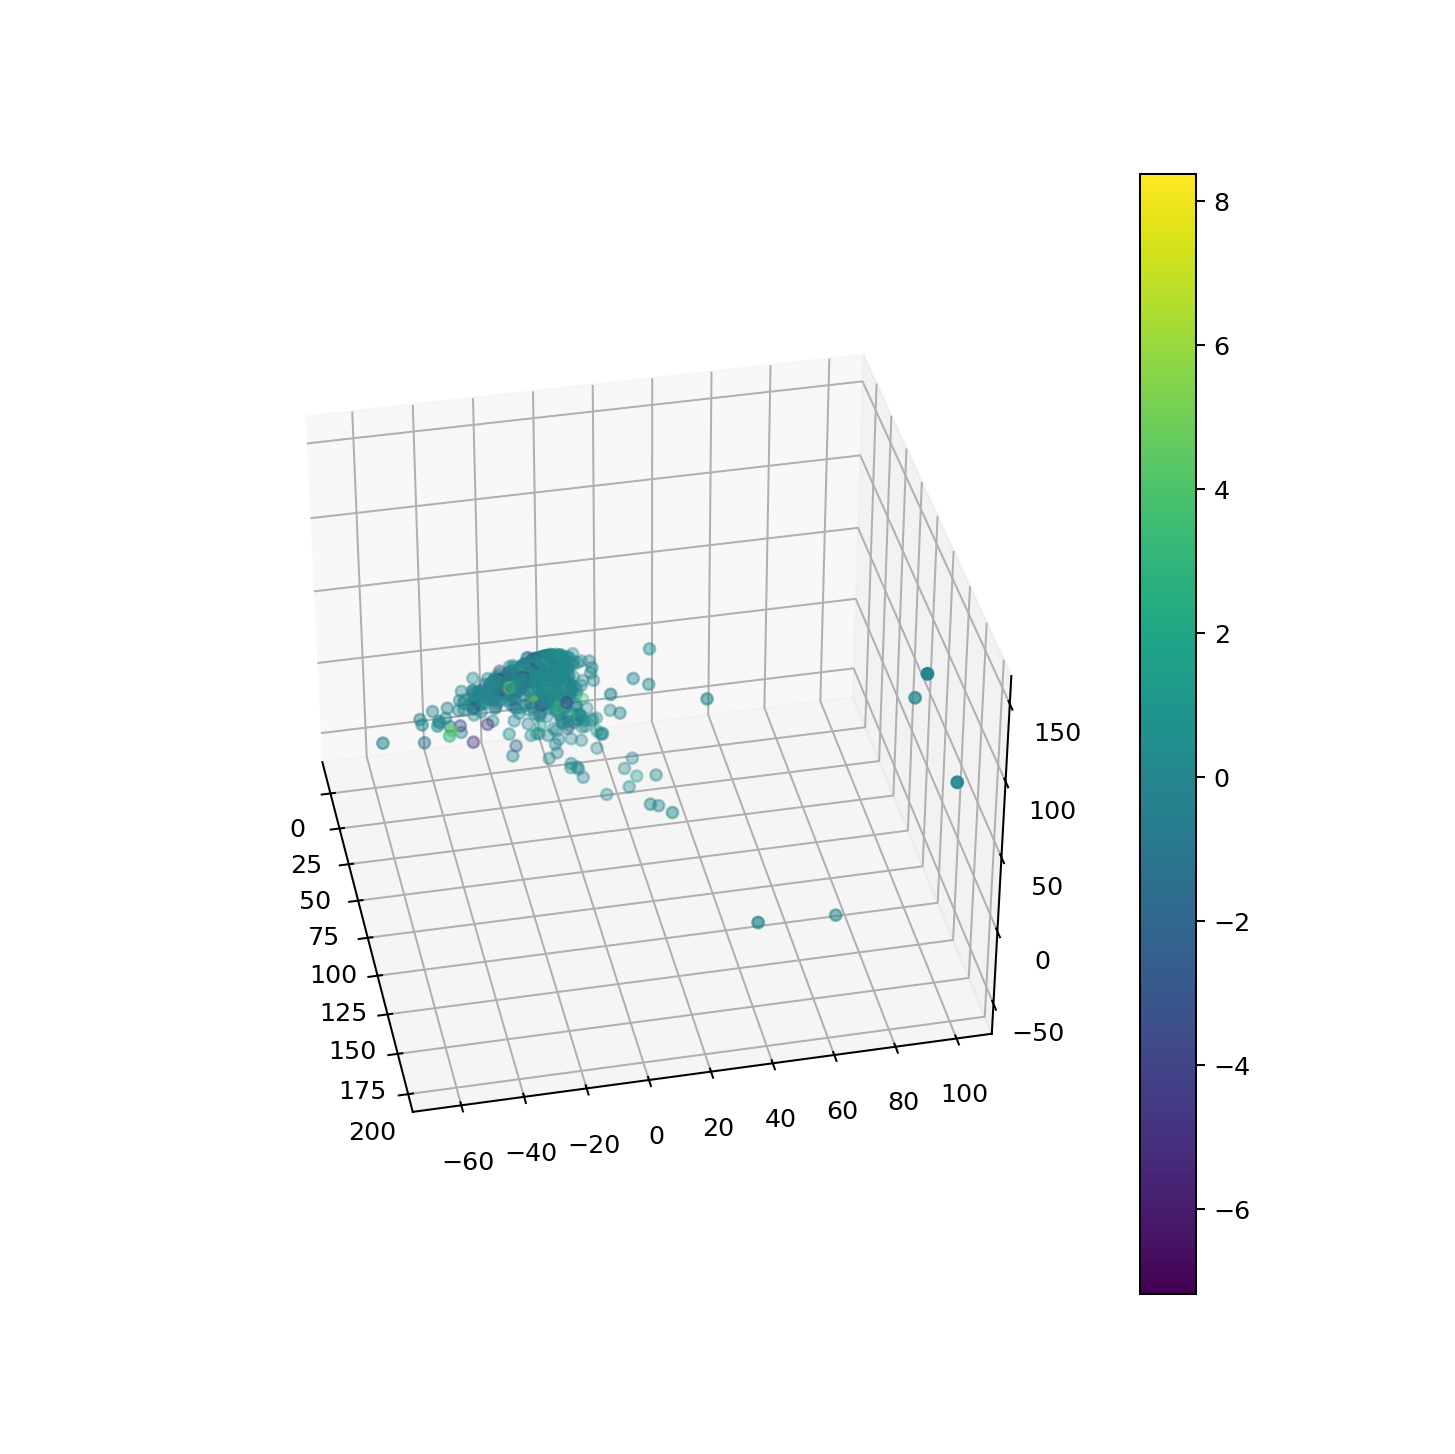

<IPython.core.display.Javascript object>


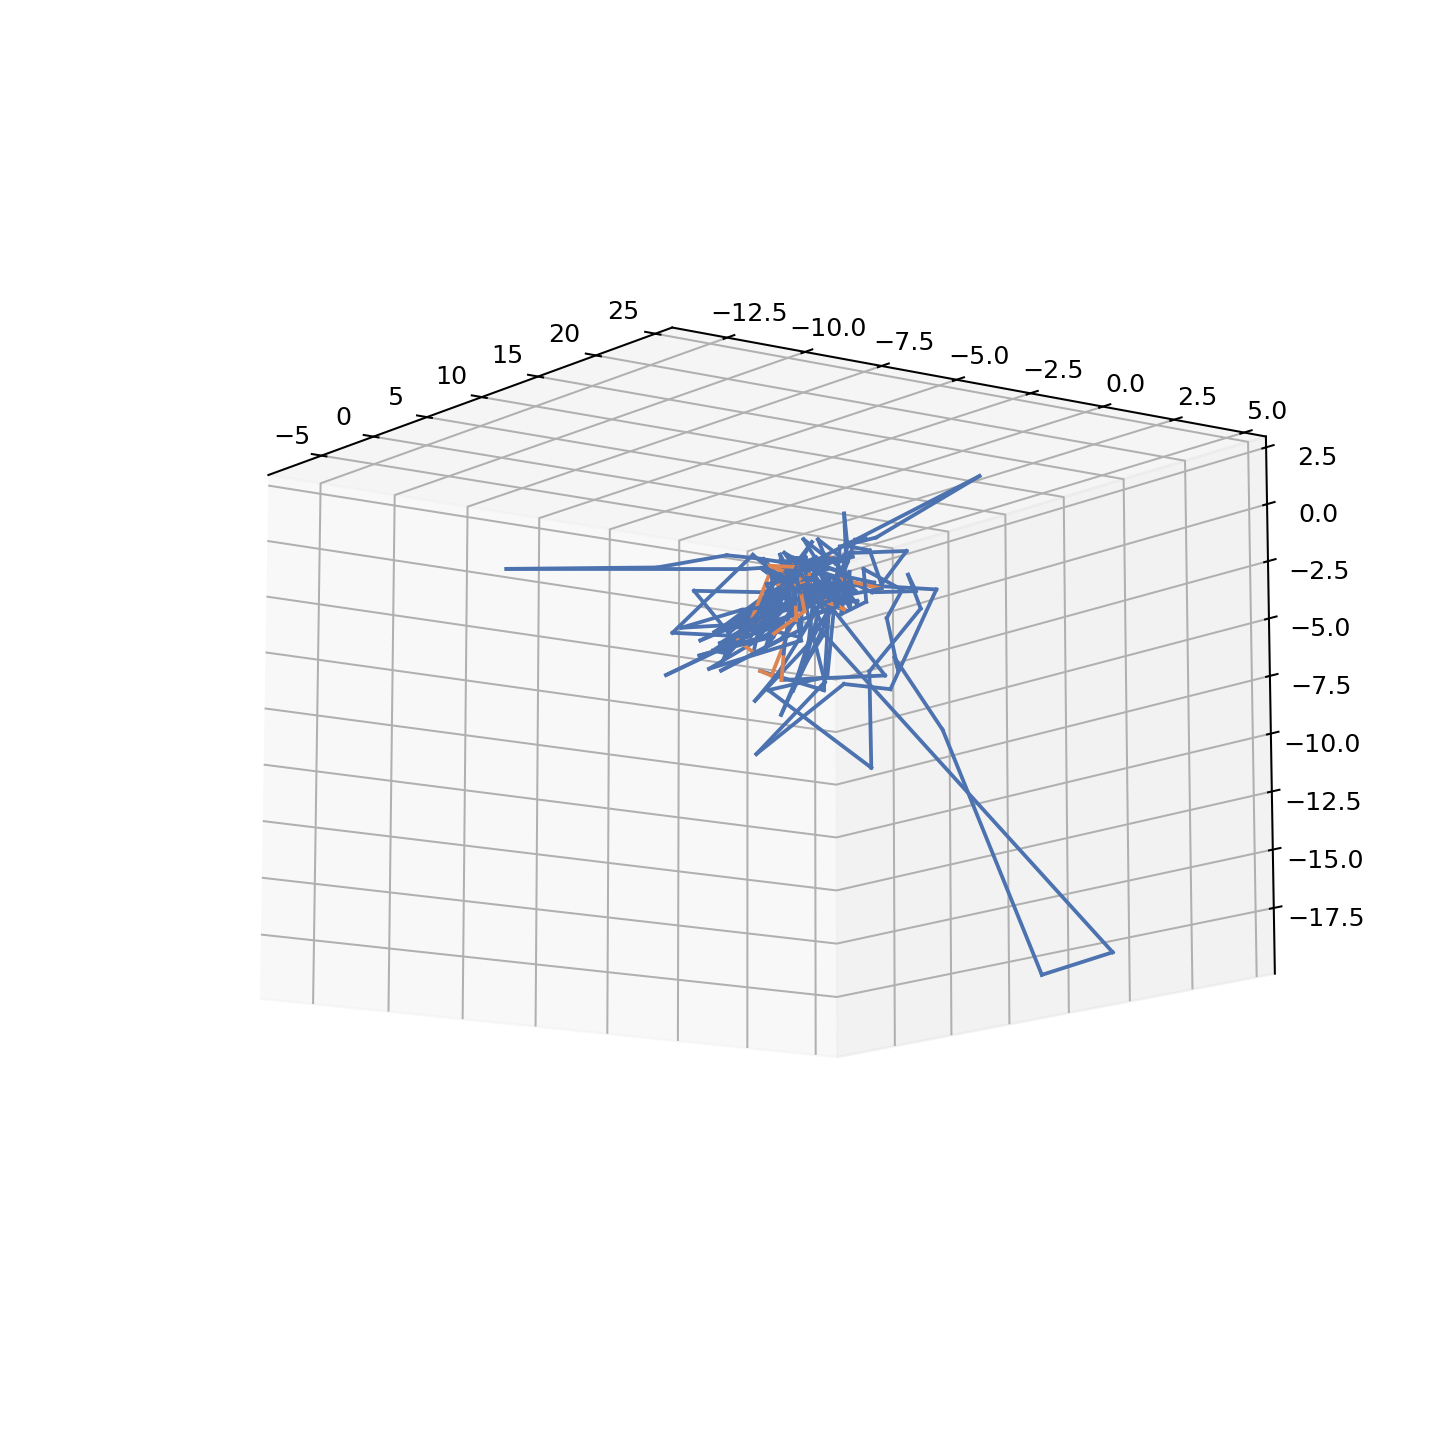

IndexError: list index out of range

In [88]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
true_y_line = ax.scatter(Y0_pca[:, 0], Y0_pca[:, 1], Y0_pca[:, 2], c=B_[:,0])
plt.colorbar(true_y_line)
plt.show()

plot_phase_space(Y0_pca, B_[:,1].astype(int), state_names = ['0', '1'])